In [6]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Définir les transformations pour les images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner à 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Charger le dataset Flowers102 avec les transformations définies
dataset = datasets.Flowers102(root='./data', split='train', transform=transform, download=True)

# Diviser le dataset en ensembles d'entraînement (80%) et de test (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Créer les DataLoader pour l'entraînement et le test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
# Charger le modèle pré-entraîné ResNet18
model = models.resnet18(pretrained=True)

# Remplacer la couche fully connected pour correspondre au nombre de classes dans Flowers102
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

# Définir l'optimiseur et la fonction de perte
optimiseur = optim.Adam(model.parameters(), lr=0.001)
critere = nn.CrossEntropyLoss()

/Users/mariegestel/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mariegestel/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/mariegestel/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:13<00:00, 3.47MB/s]


In [4]:
# Paramètres d'entraînement
epochs = 25
Perte = []
acc = []

# Utiliser GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoque in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, etiquettes in train_loader:
        images, etiquettes = images.to(device), etiquettes.to(device)
        optimiseur.zero_grad()
        sorties = model(images)
        perte = critere(sorties, etiquettes)
        perte.backward()
        optimiseur.step()
        running_loss += perte.item()
    
    Perte.append(running_loss / len(train_loader))
    
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for images, etiquettes in test_loader:
            images, etiquettes = images.to(device), etiquettes.to(device)
            sorties = model(images)
            _, predit = torch.max(sorties.data, 1)
            total += etiquettes.size(0)
            correct += (predit == etiquettes).sum().item()
    
    precision = 100 * correct / total
    acc.append(precision)
    
    if epoque % 5 == 0:
        print(f'Époque : {epoque}, Perte : {running_loss / len(train_loader)}, Précision : {precision}')

print(f'Nombre d\'images dans le dataset original: {len(dataset)}')
print(f'Nombre d\'images dans le train_loader: {len(train_loader.dataset)}')
print(f'Nombre d\'images dans le test_loader: {len(test_loader.dataset)}')


Époque : 0, Perte : 3.805476555457482, Précision : 25.0
Époque : 5, Perte : 0.029064920014486864, Précision : 72.54901960784314
Époque : 10, Perte : 0.002719340013125195, Précision : 77.94117647058823
Époque : 15, Perte : 0.0015523602845720374, Précision : 77.94117647058823
Époque : 20, Perte : 0.0012268209852314054, Précision : 79.41176470588235
Nombre d'images dans le dataset original: 1020
Nombre d'images dans le train_loader: 816
Nombre d'images dans le test_loader: 204


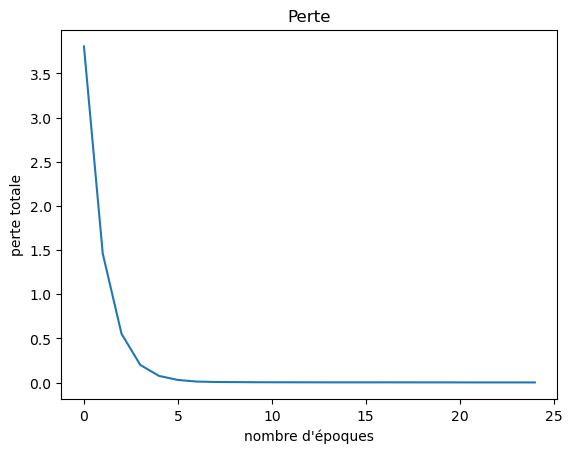

In [7]:
plt.plot(Perte)
plt.xlabel("nombre d'époques")
plt.ylabel("perte totale")
plt.title("Perte")
plt.show()

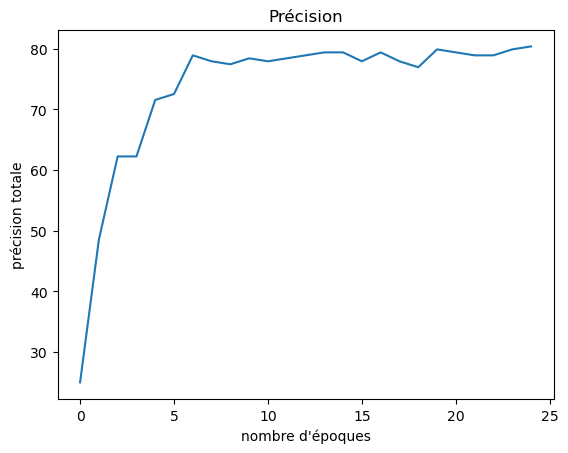

In [8]:
plt.plot(acc)
plt.xlabel("nombre d'époques")
plt.ylabel("précision totale")
plt.title("Précision")
plt.show()